In [1]:
import time
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit.primitives import Sampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit.primitives import StatevectorSampler, BackendSamplerV2
import os
from qiskit_ibm_runtime import QiskitRuntimeService

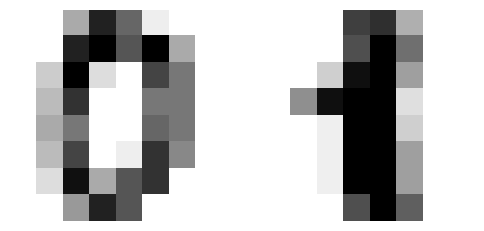

Saved test_digits/digit_0.png and digit_1.png


In [2]:
# Load the digits dataset
digits = load_digits(n_class=2)
fig, axs = plt.subplots(1, 2, figsize=(6,3))
axs[0].set_axis_off()
axs[0].imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation='nearest')
axs[1].set_axis_off()
axs[1].imshow(digits.images[1], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

# Find one image of 0 and one of 1
img_0 = next((img for img, label in zip(digits.images, digits.target) if label == 0), None)
img_1 = next((img for img, label in zip(digits.images, digits.target) if label == 1), None)

# Create output directory
os.makedirs("test_digits", exist_ok=True)

# Save images
plt.imsave("test_digits/digit_0.png", img_0, cmap="gray")
plt.imsave("test_digits/digit_1.png", img_1, cmap="gray")

print("Saved test_digits/digit_0.png and digit_1.png")

In [3]:
# Split dataset
sample_train, sample_test, label_train, label_test = train_test_split(
    digits.data, digits.target, test_size=0.2, random_state=22
)

# Reduce dimensions
n_dim = 4
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# Normalize
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# Scale
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# Select
train_size = 100
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 20
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]

In [4]:
service = QiskitRuntimeService(channel="ibm_quantum")
service.active_account()

{'channel': 'ibm_quantum',
 'url': 'https://auth.quantum.ibm.com/api',
 'token': '7c2e5340c82a9cc6aae2a750b51b2af4317f94cdb6faf9769401b8cb603157f428e24b8e67bb9ddd2d60de82ba2f499727ba6824ee415f3a9ccf2d3b908a114c',
 'verify': True,
 'private_endpoint': False}

In [5]:
map_zz = ZZFeatureMap(feature_dimension=4, reps=2, entanglement='linear', insert_barriers=True)


for backend in service.backends(simulator=False):
    print(backend.name)

backend = service.backend("ibm_brisbane")

# Define a sampler
sampler = StatevectorSampler()

# Use ComputeUncompute fidelity method
fidelity = ComputeUncompute(sampler=sampler)
quantum_kernel = FidelityQuantumKernel(feature_map=map_zz, fidelity=fidelity)

# Compute kernel matrix
start_time = time.time()  # Start timer
kernel_matrix = quantum_kernel.evaluate(sample_train)  # Run the function
kernel_test = quantum_kernel.evaluate(sample_test, sample_train)
end_time = time.time()  # End timer

execution_time = end_time - start_time  # Calculate time taken
print(f"Execution Time: {execution_time:.4f} seconds")

svm = SVC(kernel="precomputed")
svm.fit(kernel_matrix, label_train)

# store the model parameters in db

y_pred = svm.predict(kernel_test)
accuracy = accuracy_score(label_test, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")

ibm_brisbane
ibm_sherbrooke
Execution Time: 130.5646 seconds
Test Accuracy: 0.9000


In [ ]:
def load_data(data_dir):
    images = []
    labels = []

    for label in os.listdir(data_dir):
        for img in os.listdir(os.path.join(data_dir, label)):
            img_path = os.path.join(data_dir, label, img)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (64, 64))
            images.append(img.flatten())
            labels.append(0 if label == 'no_tumor' else 1)

    return np.array(images), np.array(labels)